# ANALYSE DES MOTS ECRITS A LA MAIN

## Création d'un dataframe contenant les chemin d'accès aux différents fichiers

In [1]:
import os
import glob
import pathlib
from collections import Counter

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import string

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers

### Indication du chemin d'accès aux différentes images et décompte de celles-ci.

In [2]:
# Chemin d'accès aux fichiers de phrases. Ce sont tous des fichiers .png
myDir = r"C:\Users\Xavier\Documents\Datascientest\Projet\Donneesraw\words"

# Trouver toutes les chemins vers les fichiers qui finissent par .png
data_dir = pathlib.Path(myDir)
words = sorted(list(map(str, list(data_dir.glob("*/*/*.png")))))

# Nombre de fichiers trouvés
words_count = len(words)
print('Nombre de fichiers images de mots :',words_count)

Nombre de fichiers images de mots : 115320


### Construction d'un premier dataframe contenant les chemins d'accès et le nom des fichiers 

In [3]:
# Extraction du label de chaque image
images = list(map(lambda x : [x, x.split('\\')[-1].split(".png")[0]], words))

In [4]:
# Création d'un dataframe
df = pd.DataFrame(images, columns=['filepath', 'words_id'])
df.head()

,filepath,words_id
0,C:\Users\Xavier\Documents\Datascientest\Projet...,a01-000u-00-00
1,C:\Users\Xavier\Documents\Datascientest\Projet...,a01-000u-00-01
2,C:\Users\Xavier\Documents\Datascientest\Projet...,a01-000u-00-02
3,C:\Users\Xavier\Documents\Datascientest\Projet...,a01-000u-00-03
4,C:\Users\Xavier\Documents\Datascientest\Projet...,a01-000u-00-04


In [5]:
#supression des fichiers corrompus
import cv2
corrupt_files = []
corrupt_index = []
# Identification et collecte des fichiers corrompus
for index, path in enumerate(df.filepath):
    try:
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
    except:
        corrupt_files.append(path)
        corrupt_index.append(index)
# Suppression des fichiers corrompus
df= df.drop(index=corrupt_index)

### Exploitation du fichier xml pour la construction d'un second dataframe [nom du fichier, transcription]

<ul> Cette exploitation a pour objectif de coupler la transcription du mot contenu dans l'image, au nom du fichier de ladite image. </ul>

In [6]:
#lecture du fichier XML créé précédement
fichier_xml = './xml.csv'
fichier = pd.read_csv(fichier_xml,index_col=[0])

# Création du dataframe
df1 = fichier[['id','text']].rename({'id':'words_id','text':'label'}, axis = 1)

#### Suppression des doublons.
df1 = df1.drop_duplicates()

#### Tri par ordre croissant par rapport à la colonne 'words_id'.
df1 = df1.sort_values(by ='words_id', axis= 0)

# Couplage des deux dataframes et création de notre dataset.
data = pd.merge(df, df1, on = ['words_id'])
data.head()

,filepath,words_id,label
0,C:\Users\Xavier\Documents\Datascientest\Projet...,a01-000u-00-00,A
1,C:\Users\Xavier\Documents\Datascientest\Projet...,a01-000u-00-01,MOVE
2,C:\Users\Xavier\Documents\Datascientest\Projet...,a01-000u-00-02,to
3,C:\Users\Xavier\Documents\Datascientest\Projet...,a01-000u-00-03,stop
4,C:\Users\Xavier\Documents\Datascientest\Projet...,a01-000u-00-04,Mr.


<ul> Ici nous avons choisi la méthode <b>'inner'</b> pour le couplage des deux dataframes car tous les fichiers semblent ne pas avoir de transcription.</ul>
<ul> Ce qui parait logique vue la segmentation n'a pas été correcte pour tous les mots de chaque formulaire.</ul>
<ul> Nous nous restreignons par conséquent aux fichiers dont la segmentation a été correcte.</ul> 

In [7]:
print('Nombre de labels uniques dans la transcription : ',len(data.label.unique()))

Nombre de labels uniques dans la transcription :  13550


In [11]:
# Longueur maximale des transcriptions dans le dataset
max_length = max([len(label) for label in data.label])
print('Valeur du plus long mot : ', max_length)

Valeur du plus long mot :  21


In [24]:
# Ici nous effectuons un tri pour savoir quels sont les mots les plus longs

for index, txt in enumerate(data.label):
    if len(txt) >= 18 :# max_length - 35 :
        print('Indice : ',index, 'Mot : ',txt, 'Longueur :', len(txt))

Indice :  5699 Mot :  counter-revolution Longueur : 18
Indice :  30291 Mot :  brilliantly-written Longueur : 19
Indice :  45936 Mot :  over-simplification Longueur : 19
Indice :  46230 Mot :  neuro-physiologists Longueur : 19
Indice :  69061 Mot :  travelling-carriage Longueur : 19
Indice :  80764 Mot :  plate-and-corrugation Longueur : 21
Indice :  93418 Mot :  middle-income-bracket Longueur : 21
Indice :  102833 Mot :  Lieutenant-Commander Longueur : 20


In [110]:
print("""On se rend compte que le mot le plus long est une succession de pointillés qui n'apparait qu'une seule fois. 
Par aileurs, la plupart des mots sont de longueur inférieure ou égale à 21. Nous allons donc supprimer ce plus 
long mot qui apparait comme une valeur aberrante dans notre dataframe. """)

On se rend compte que le mot le plus long est une succession de pointillés qui n'apparait qu'une seule fois. 
Par aileurs, la plupart des mots sont de longueur inférieure ou égale à 21. Nous allons donc supprimer ce plus 
long mot qui apparait comme une valeur aberrante dans notre dataframe. 


In [10]:
# Mise à jour du dataframe par suppression du plus long mot

data = data.drop(index=106922).reset_index(drop=True)

In [12]:
# Mise à jour de la longueur maximale des transcriptions
max_length = max([len(label) for label in data.label])
print('Valeur du plus long mot : ', max_length)

Valeur du plus long mot :  21


## VISUALISATION DE QUELQUES IMAGES AVEC LEUR TRANSCRIPTION

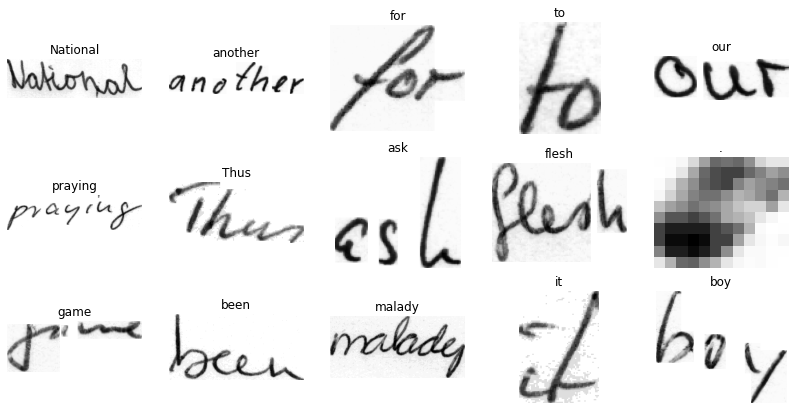

In [13]:
from matplotlib.image import imread

#Visualisation aléatoire de quelques données images.
plt.figure(figsize=(14, 7))

j=1
for i in np.random.choice(range(data.shape[0]), size = 15):
    ax = plt.subplot(3, 5, j)
    plt.imshow(imread(data.filepath[i]), cmap='gray')
    plt.title(data.label[i])
    j+=1
    plt.axis("off")

## Identification de tous les caractères présents dans la transcription

<ul> Ceci se fait par la construction d'un vocabulaire des différents caractères présents dans toute la transcription. La méthode employée permet de créer une liste de caractères triés par ordre décroissant d'occurrence. Ainsi, les indices les plus grands sont reservés au caractères les moins fréquents dans la transcription tandis que les indices les plus petits sot occupés par es caractères les plus souvent présents. Un caratère <b>[UNK]</b> est ajouté au vocabulaire pour nommé tout caractère qui se trouve hors du dictionnaire.</ul>

In [25]:
K = list(char for label in data.label for char in label) # liste de tous les caractères avec eventuellement des doublons

layer = layers.experimental.preprocessing.StringLookup() # Instanciation d'un objet StringLookup

layer.adapt(K)                                         # Cette opération filtre l'ensemble K en identifiant les valeurs uniques

Vocab = layer.get_vocabulary()                         # Vocabulaire filtré et trié par odre décroissant d'occurrence

In [26]:
print('Vocabulaire des caractères présents :', Vocab)

print("Nombre de caractères uniques :", len(Vocab))

Vocabulaire des caractères présents : ['', '[UNK]', 'e', 't', 'a', 'o', 'n', 'i', 's', 'r', 'h', 'l', 'd', 'u', 'c', 'm', 'f', 'w', 'g', 'y', 'p', 'b', '.', ',', 'v', 'k', "'", 'T', 'I', '"', '-', 'A', 'M', 'S', 'H', 'B', 'x', 'C', 'W', 'P', 'N', 'E', 'G', 'L', 'R', 'D', '1', 'F', 'O', '0', 'j', 'q', '?', 'Y', '!', '2', 'z', ';', '(', ')', 'U', 'J', '9', '3', 'V', ':', 'K', '5', '6', '8', '4', '#', '7', '&', ' ', 'Q', '/', '*', 'Z', '+', 'X']
Nombre de caractères uniques : 81


## Preprocessing

In [28]:
# Association des caractères aux entiers. Ceci servira pour l'encodage des labels
char_to_num = layers.experimental.preprocessing.StringLookup(vocabulary = Vocab)

# Association des entiers aux caractères. Ceci servira pour le décodage des labels codés.
num_to_char = layers.experimental.preprocessing.StringLookup(vocabulary = char_to_num.get_vocabulary(), invert = True)

### Encodage et uniformisation de l'encodage des mots 

<ul> La fonction definie ci-dessous va permettre d'encoder chaque caractère présent dans la transcription de chaque image. L'objectif ici étant de pouvoir encoder chaque mot transcrit à l'aide des différents caractères qui le constituent.</ul>

In [29]:
def encode_to_labels(txt):
    ''' Cette fonction transforme un mot en une liste de nombres.
    La liste a la longueur du mot qu'il remplace et est remplie de la gauche vers la droite. 
    Chaque nombre indique le rang de la lettre qu'il remplace.
    ''' 
    
    dig_lst = []
    for index, char in enumerate(txt):
        dig_lst.append(Vocab.index(char))
    return dig_lst

In [18]:
encode_to_labels('txt')

[3, 36, 3]

<ul>A présent, nous allons appliquer cette fonction au dataframe <b>'data'</b> en vue de l'encodage de la colonne <b>'label'</b>.</ul>

In [30]:
# Nous commençons par encoder chaque mot à l'aide de la fonction encode_to_labels

data['encoded_label'] = data.label.apply(lambda txt: encode_to_labels(txt))

In [31]:
data.head()

,filepath,words_id,label,encoded_label,pad_label
0,C:\Users\Xavier\Documents\Datascientest\Projet...,a01-000u-00-00,A,[31],"[31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,C:\Users\Xavier\Documents\Datascientest\Projet...,a01-000u-00-01,MOVE,"[32, 48, 64, 41]","[32, 48, 64, 41, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,C:\Users\Xavier\Documents\Datascientest\Projet...,a01-000u-00-02,to,"[3, 5]","[3, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,C:\Users\Xavier\Documents\Datascientest\Projet...,a01-000u-00-03,stop,"[8, 3, 5, 20]","[8, 3, 5, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,C:\Users\Xavier\Documents\Datascientest\Projet...,a01-000u-00-04,Mr.,"[32, 9, 22]","[32, 9, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


#### Uniformisation de l'encodage

In [32]:
# Nous créons ici un array numpy pour procéder à l'uniformisation de l'encodage 
#liste = data['encoded_label'].to_numpy()

# Uniformisation
pad_words = pad_sequences(data['encoded_label'].to_numpy(),
                          maxlen= max_length,
                          padding='post',
                          value = 0)

#### Mise à jour du dataframe avec l'encodage uniformisé

In [33]:
# Duplication de la colonne ['encoded_words'] avec pour titre ['padded_words']

data['pad_label'] = data['encoded_label']


# Mise à jour de la colonne ['pad_label']

for index in range(len(data['pad_label'])):
    data['pad_label'][index] = pad_words[index]

In [34]:
data.head()

,filepath,words_id,label,encoded_label,pad_label
0,C:\Users\Xavier\Documents\Datascientest\Projet...,a01-000u-00-00,A,[31],"[31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,C:\Users\Xavier\Documents\Datascientest\Projet...,a01-000u-00-01,MOVE,"[32, 48, 64, 41]","[32, 48, 64, 41, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,C:\Users\Xavier\Documents\Datascientest\Projet...,a01-000u-00-02,to,"[3, 5]","[3, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,C:\Users\Xavier\Documents\Datascientest\Projet...,a01-000u-00-03,stop,"[8, 3, 5, 20]","[8, 3, 5, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,C:\Users\Xavier\Documents\Datascientest\Projet...,a01-000u-00-04,Mr.,"[32, 9, 22]","[32, 9, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


# Création des objets Dataset

In [29]:
# Séparation des données en etrainement et test

X_train_path, X_test_path, Y_train, Y_test = train_test_split(data.filepath, data.pad_label, train_size = .9, random_state = 1234)

In [30]:
downsample_factor = 4

img_height = 50
img_width = 200

def encode_single_image(img_path, label):
    
    # 1. lecture de l'image
    img = tf.io.read_file(img_path)
    # 2. Decodage et conversion en échelle de gris
    img = tf.io.decode_png(img, channels=1)
    # 3. Normalisation de l'image. Les valeurs des
    # pixels sont désormais entre 0 et 1.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Redimensionnement de l'image au format désiré
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transposition de l'image pour faire correspondre
    # la dimension 'temps' à la dimension 'width' de l'image.
    img = tf.transpose(img, perm=[1, 0, 2])
    
    return {"image":img, "label": label}


batch_size = 200

# Entrainement
train_data = tf.data.Dataset.from_tensor_slices((X_train_path, Y_train.to_list()))

train_data = train_data.map(encode_single_image)

train_data = train_data.shuffle(buffer_size = 2000)

train_data = train_data.batch(batch_size = batch_size)

# Validation ou test
validation_data = tf.data.Dataset.from_tensor_slices((X_test_path, Y_test.to_list()))

validation_data = validation_data.map(encode_single_image)

validation_data = validation_data.shuffle(buffer_size = 2000)

validation_data = validation_data.batch(batch_size = batch_size)

## Visualisation

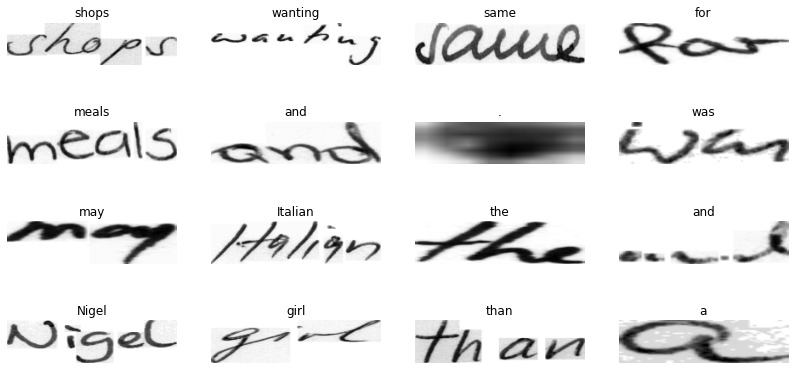

In [31]:
_, ax = plt.subplots(4, 4, figsize=(14, 7))
for batch in train_data.take(1):
    
    images = batch["image"]
    labels = batch["label"]    
    
    for i in range(16):
        
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("UTF-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

# Le modèle

In [32]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost
        
    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
        
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        
        
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # Au moment de tester, retourner juste les prédictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(Vocab) + 1, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 50, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 25, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 100, 25, 64)  18496       pool1[0][0]                      
_______________________________________________________________________________________

In [35]:
input_data = layers.Input(name='the_input', shape=(128,64,1), dtype='float32')  # (None, 128, 64, 1)

# Convolution layer (VGG)
iam_layers = layers.Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(2, 2), name='max1')(iam_layers)  # (None,64, 32, 64)

iam_layers = layers.Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(2, 2), name='max2')(iam_layers)

iam_layers = layers.Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(1, 2), name='max3')(iam_layers)  # (None, 32, 8, 256)

iam_layers = layers.Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.Conv2D(512, (3, 3), padding='same', name='conv6')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(1, 2), name='max4')(iam_layers)

iam_layers = layers.Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)

# CNN to RNN
iam_layers = layers.Reshape(target_shape=((32, 2048)), name='reshape')(iam_layers)
iam_layers = layers.Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(iam_layers)

# RNN layer
# layer ten
iam_layers = layers.Bidirectional(layers.LSTM(units=256, return_sequences=True))(iam_layers)
# layer nine
iam_layers = layers.Bidirectional(layers.LSTM(units=256, return_sequences=True))(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)

# transforms RNN output to character activations:
iam_layers = layers.Dense(80, kernel_initializer='he_normal', name='dense2')(iam_layers)
iam_outputs = layers.Activation('softmax', name='softmax')(iam_layers)

labels = layers.Input(name='the_labels', shape=[16], dtype='float32')
input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
label_length = layers.Input(name='label_length', shape=[1], dtype='int64')


def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return tf_keras_backend.ctc_batch_cost(labels, y_pred, input_length, label_length)



model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)
model.summary()

NameError: name 'Model' is not defined

## Entrainement

In [33]:
## Les callbacks

# Ajout d'un early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss",
                                               patience= 5,
                                               restore_best_weights=True,
                                               verbose=1)

# Sauvegarde des poids à chaque epoch
checkpoint = keras.callbacks.ModelCheckpoint(filepath = "checkpoint.hdf5", 
                                       monitor = 'val_loss',
                                       save_best_only = True,
                                       save_weights_only = False,
                                       mode = 'min',
                                       save_freq = 'epoch')


callbacks_list = [checkpoint, early_stopping]

In [43]:
import imghdr
import os

l_FileNames = os.listdir(r"C:\Users\Xavier\Documents\Datascientest\Projet\Donneesraw\words")

for image in l_FileNames:
    if not imghdr.what(image) == "png":
        l_FileNames.remove(image)

FileNotFoundError: [Errno 2] No such file or directory: 'a01'

In [39]:
cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in 'C:\\Users\\Xavier': ['.bash_history', '.cache', '.conda', '.condarc', '.dbus-keyrings', '.git', '.ipynb_checkpoints', '.ipython', '.jupyter', '.keras', '.matplotlib', '.spyder-py3', '.streamlit', '.thumbnails', '.vscode', '123_2.ipynb', '1429_1.csv', '3D Objects', 'a01-000u-00-01.png', 'a01-000u.png', 'amazon.csv', 'anaconda3', 'AppData', 'Application Data', 'Cartes heuristique Df.xml', 'Clustering_module123.ipynb', 'Contacts', 'Cookies', 'creditcard.csv', 'Desktop', 'Devoir 123.ipynb', 'Documents', 'Downloads', 'Eval_module_135.ipynb', 'exam124.ipynb', 'Examen 131.ipynb', 'Examen 135.ipynb', 'Examen 135_jo.ipynb', 'Examen_125.csv', 'Examen_125.ipynb', 'Examen_125_2.csv', 'Examen_127.ipynb', 'Exam_141.ipynb', 'Exam_151.ipynb', 'Exam_155.ipynb', 'exam_python.ipynb', 'face_boxe.csv', 'Favorites', 'fichier 2', 'fichier1', 'fichier2', 'fond_wordflow.png', 'Form.csv', 'forms.txt', 'git_tuto2', 'house_price.csv', 'house_price.txt', 'IntelGraphicsProfiles', 'lines.csv', 'lines.txt',

In [35]:
os.listdir(r"C:\Users\Xavier\Documents\Datascientest\Projet\Donneesraw\words")


['a01',
 'a02',
 'a03',
 'a04',
 'a05',
 'a06',
 'b01',
 'b02',
 'b03',
 'b04',
 'b05',
 'b06',
 'c01',
 'c02',
 'c03',
 'c04',
 'c06',
 'd01',
 'd03',
 'd04',
 'd05',
 'd06',
 'd07',
 'e01',
 'e02',
 'e04',
 'e06',
 'e07',
 'f01',
 'f02',
 'f03',
 'f04',
 'f07',
 'g01',
 'g02',
 'g03',
 'g04',
 'g05',
 'g06',
 'g07',
 'h01',
 'h02',
 'h04',
 'h05',
 'h06',
 'h07',
 'j01',
 'j04',
 'j06',
 'j07',
 'k01',
 'k02',
 'k03',
 'k04',
 'k07',
 'l01',
 'l03',
 'l04',
 'l07',
 'm01',
 'm02',
 'm03',
 'm04',
 'm06',
 'n01',
 'n02',
 'n03',
 'n04',
 'n06',
 'p01',
 'p02',
 'p03',
 'p06',
 'r02',
 'r03',
 'r06']

In [ ]:
##### Entrainement

epochs = 100


history = model.fit(
    train_data,
    validation_data = validation_data,
    epochs=epochs,
    callbacks=callbacks_list
)

## Déduction - Prédiction - Conclusion

In [ ]:
# Récupération du modèle de prediction

prediction_model = keras.models.Model(model.get_layer(name="image").input,
                                      model.get_layer(name="dense2").output
                                     )
prediction_model.summary()

In [ ]:
# Fonction de décodage de l'output du réseau

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    
    # Utilisation de la méthode greedy search.
    results = keras.backend.ctc_decode(pred,
                                       input_length=input_len,
                                       greedy=True)[0][0][:, :max_length]
    
    # Iteration sur les résultats pour décoder le label
    output_text = []
    
    for res in results:
        
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
        
    return output_text



In [ ]:
#  Vérification des résultats sur quelques échantillons de validation

for batch in validation_dataset.take(1):
    
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    
    orig_texts = []
    
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
        
plt.show()